# Water Quality - Total Suspended Matter
This notebook shows results for three empirical algorithms and one spectral index addressing total suspended sediment (TSM), or total suspended matter (TSM). It should be noted that these algorithms were developed for specific regions of the world and are not valid universally. In addition, the Landsat-8 data is standard surface reflectance and not water leaving radiance, so the accuracy of the results are likely worse since water radiance is very low and small differences in atmospheric corrections can vastly change the results. Finally, the colorbar (legend) for these results have been removed to avoid showing specific quantities for the TSM results. It is best to use these results to assess coarse spatial and temporal differences (e.g. low, medium, high). With improvements in analysis-ready data (e.g. water leaving radiance) and with in-situ sampling of water bodies for empirical modeling, it will be possible to increase the accuracy of these water quality results and even consider the numerical output.

It should also be noted that this notebook is best used with the "Cloud Statistics" notebook in order to identify clear scenes with no cloud contamination. 

In [1]:
# Supress Warning 
import warnings
warnings.filterwarnings('ignore')

import datacube
dc = datacube.Datacube(app = 'my_app', config = '/home/localuser/.datacube.conf')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np  
import xarray as xr  

import utils.data_cube_utilities.data_access_api as dc_api  
api = dc_api.DataAccessApi(config = '/home/localuser/.datacube.conf')

In [2]:
# Select a Product and Platform
# Examples: ghana, kenya, tanzania, sierra_leone, senegal
# The water quality community typically uses Landsat-8 vs. Landsat-7 due to its increased SNR

product = "ls8_lasrc_tanzania"
platform = "LANDSAT_8"

# product = "ls8_lasrc_ghana"
# platform = "LANDSAT_8"

In [3]:
# Get Coordinates of the selected cube and print them
coordinates = api.get_full_dataset_extent(platform = platform, product = product)

latitude_extents = (min(coordinates['latitude'].values),max(coordinates['latitude'].values))
longitude_extents = (min(coordinates['longitude'].values),max(coordinates['longitude'].values))
time_extents = (min(coordinates['time'].values),max(coordinates['time'].values))

print( latitude_extents )
print( longitude_extents )
print( time_extents )

(-11.999019059879926, -0.0001356388440351325)
(28.998784571651935, 40.99806659404953)
(numpy.datetime64('2013-04-12T07:52:20.000000000'), numpy.datetime64('2018-01-01T07:21:24.000000000'))


In [4]:
# Select an analysis region (Lat-Lon) within the extents listed above. 
# Select a time period (Min-Max) within the extents listed above (Year-Month-Day)

# Northern Lake Manyara, Tanzania
# Clear dates: 1/25/14, 2/13/15, 2/16/16, 1/17/17, 12/3/17
latitude =  (-3.5935, -3.3885) 
longitude =  (35.7136, 35.9386)

# Weija Reservoir, Ghana
# Clear date: 1/12/2018
# latitude =  (5.541, 5.625) 
# longitude =  (-0.404, -0.328)

# Time Period
time_extents = ('2016-02-15', '2016-02-17')


In [5]:
# The code below renders a map that can be used to view the region.
from utils.data_cube_utilities.dc_display_map import display_map
display_map(latitude,longitude)

## Load the dataset and the required spectral bands

In [6]:
landsat_dataset = dc.load(latitude = latitude,
                          longitude = longitude,
                          platform = platform,
                          time = time_extents,
                          product = product,
                          measurements = ['red', 'green', 'blue', 'nir', 'swir1', 'swir2', 'pixel_qa']) 

In [7]:
# Displays the first few values of each data array to check the content
# Latitude and Longitude numbers = number of pixels in each dimension
# Time = number of time slices in the dataset

landsat_dataset

<xarray.Dataset>
Dimensions:    (latitude: 757, longitude: 831, time: 1)
Coordinates:
  * time       (time) datetime64[ns] 2016-02-16T07:49:41
  * latitude   (latitude) float64 -3.388 -3.389 -3.389 ... -3.593 -3.593 -3.593
  * longitude  (longitude) float64 35.71 35.71 35.71 35.71 ... 35.94 35.94 35.94
Data variables:
    red        (time, latitude, longitude) int16 558 612 620 607 ... 482 516 532
    green      (time, latitude, longitude) int16 458 502 492 492 ... 643 639 640
    blue       (time, latitude, longitude) int16 277 294 292 288 ... 307 319 328
    nir        (time, latitude, longitude) int16 1311 1483 1449 ... 2345 2306
    swir1      (time, latitude, longitude) int16 1437 1500 1500 ... 1481 1475
    swir2      (time, latitude, longitude) int16 1189 1229 1225 ... 880 911 934
    pixel_qa   (time, latitude, longitude) int32 322 322 322 322 ... 322 322 322
Attributes:
    crs:      EPSG:4326

### Mask out clouds and cloud shadows + water and create a median mosaic

In [8]:
from utils.data_cube_utilities.clean_mask import landsat_qa_clean_mask
# Land and Water Dataset = Land and Water pixels with NO Clouds and NO Cloud Shadows
cloud_mask = landsat_qa_clean_mask(landsat_dataset, platform=platform)
land_and_water_dataset = landsat_dataset.where(cloud_mask)

In [9]:
from utils.data_cube_utilities.dc_mosaic import create_median_mosaic
# Create a median mosaic for viewing only
land_and_water_composite = create_median_mosaic(land_and_water_dataset, cloud_mask)

In [10]:
from utils.data_cube_utilities.dc_water_classifier import wofs_classify
# WOFS water classification 
water_classification = wofs_classify(land_and_water_composite, mosaic = True) 
# Create a mask for water-only pixels (used for water quality calculations)
water_dataset = land_and_water_composite.where(water_classification.wofs == 1)

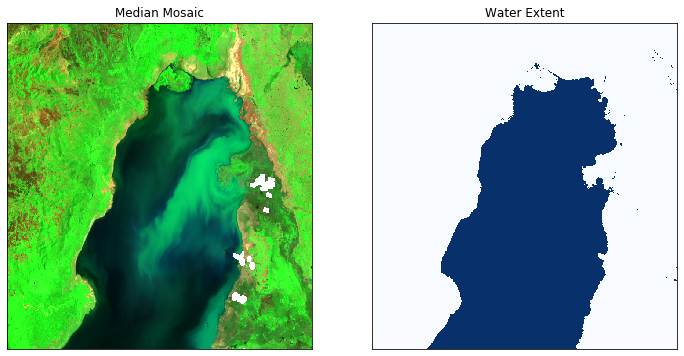

In [11]:
from utils.data_cube_utilities.dc_rgb import rgb
fig, ax = plt.subplots(1, 2, figsize=(12,6))

composite_rgb = land_and_water_composite[['swir2', 'nir', 'green']].to_array()

# Use the middle values of the data (2% to 98%) to brighten the image
rgb_vmin = composite_rgb.quantile(0.02).values
rgb_vmax = composite_rgb.quantile(0.98).values

# Plot the resulting 2 products ... Baseline RGB, Water Extent
composite_rgb.plot.imshow(ax=ax[0], vmin=rgb_vmin, vmax=rgb_vmax)
water_classification.wofs.plot.imshow(ax=ax[1], cmap='Blues', add_colorbar=False)

# Titles
ax[0].set_title('Median Mosaic'), ax[0].xaxis.set_visible(False), ax[0].yaxis.set_visible(False)
ax[1].set_title('Water Extent'), ax[1].xaxis.set_visible(False), ax[1].yaxis.set_visible(False)

plt.show()

## Total Suspended Sediment Algorithms

### (1) Lymburner TSM (Total Suspended Matter) Algorithm
Units of mg/L concentration
<br>TSM Index = T = (Green + Red) / 2
<br>TSM for L7 = 3983 * T ^ 1.6246
<br>TSM for L8 = 3957 * T ^ 1.6436

In [12]:
def LYM7(dataset):
        return (3983 * ((dataset.green + dataset.red)*0.0001/2)**1.6246)

In [13]:
def LYM8(dataset):
        return (3957 * ((dataset.green + dataset.red)*0.0001/2)**1.6436)

In [14]:
lym7 = LYM7(water_dataset)  # L7 Lymburner TSM
lym8 = LYM8(water_dataset)  # L8 Lymburner TSM

### (2) Suspended Particulate Model (SPM)
Zhongfeng Qiu et.al., 2017<br>
Using Landsat 8 data to estimate suspended particulate matter in the Yellow River estuary<br>
J. Geophys. Res. Oceans, 122, doi:10.1002/2016JC012412 <br>
<br>X = L8/OLI band ratio B4/B3 = Red/Green
<br>SPM = 10^ (2.26 X^3 - 5.42 X^2 + 5.58 X - 0.72) - 1.43
<br>SPM units in g/m^3, r^2 correlation 0.92

In [15]:
def SPM_QIU(dataset):
        return (10**(2.26*(dataset.red/dataset.green)**3 - 
                     5.42*(dataset.red/dataset.green)**2 +
                     5.58*(dataset.red/dataset.green) - 0.72) - 1.43)

In [16]:
spm_qiu = SPM_QIU(water_dataset) 

### (3) NDSSI - Normalized Difference Suspended Sediment Index
Hossain et.al., 2010 <br>
Development of Remote Sensing Based Index for Estimating/Mapping Suspended Sediment Concentration in River and Lake Environments
<br>NDSSI = (Blue-NIR)/(Blue+NIR)
<br>The NDSSI value ranges from -1 to +1. Values closer to +1 indicate presence of higher sediment

In [17]:
def NDSSI(dataset):
        return ((dataset.blue-dataset.nir)/(dataset.blue+dataset.nir))

In [18]:
ndssi = NDSSI(water_dataset) 

### (4) Quang Total Suspended Solids (TSS) Algorithm
2017 paper, Vietnam lake turbidity testing 
<br> TSS (Total Suspended Solids) units of mg/L
<br>Uses Band-4 (Red) for Landsat-8 in a linear model
<br>TSS = 380.32 * B4 - 1.7826


In [19]:
def QUANG8(dataset):
        return (380.32 * (dataset.red)*0.0001 - 1.7826)

In [20]:
quang8 = QUANG8(water_dataset) 



Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)


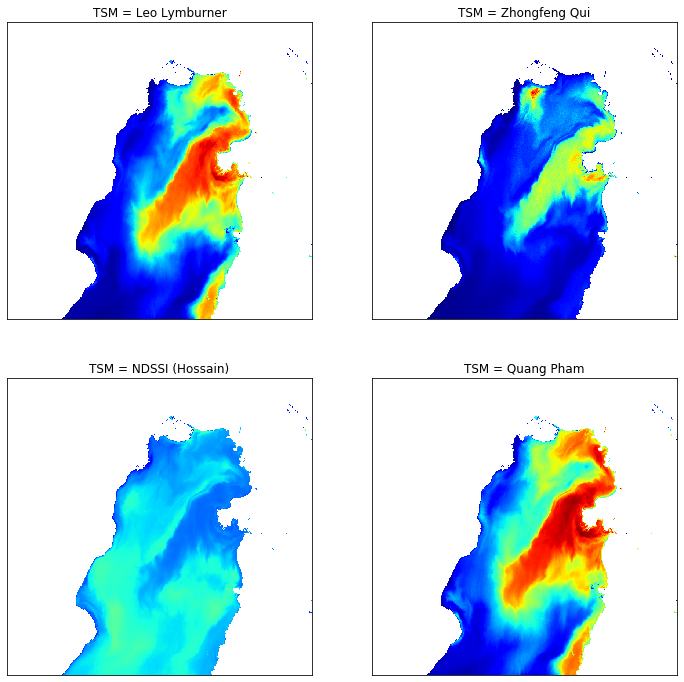

In [21]:
fig, ax = plt.subplots(2, 2, figsize=(12,12))

(lym8).plot.imshow(ax=ax[0,0], cmap = "jet", add_colorbar=False)
(spm_qiu).plot.imshow(ax=ax[0,1], cmap = "jet", add_colorbar=False)
(ndssi).plot.imshow(ax=ax[1,0], cmap = "jet", vmin=-1.0, vmax=1.0, add_colorbar=False)
(quang8).plot.imshow(ax=ax[1,1], cmap = "jet", add_colorbar=False)

print(), print()
print('Total Suspended Matter (Blue=Low, Green=Medium-Low, Orange=Medium-High, Red=High)')

# Titles
ax[0,0].set_title('TSM = Leo Lymburner'), ax[0,0].xaxis.set_visible(False), ax[0,0].yaxis.set_visible(False)
ax[0,1].set_title('TSM = Zhongfeng Qui'), ax[0,1].xaxis.set_visible(False), ax[0,1].yaxis.set_visible(False)
ax[1,0].set_title('TSM = NDSSI (Hossain)'), ax[1,0].xaxis.set_visible(False), ax[1,0].yaxis.set_visible(False)
ax[1,1].set_title('TSM = Quang Pham'), ax[1,1].xaxis.set_visible(False), ax[1,1].yaxis.set_visible(False)
# ax[1,1].set_title('TSM = Quang'), ax[1,1].axis('off') - sets entire axis off

plt.show()